In [77]:
# Linear Algebra
using LinearAlgebra
using Arpack 

# Statistics
using StatsBase
using Statistics
using Combinatorics

# Plotting
using Plots
pyplot()
using LaTeXStrings

# File IO
using FileIO
using JLD2

# DMD
push!(LOAD_PATH, "./DMF.jl/DMF.jl/src/")
using DMF

# Useful Functions

In [43]:
"""
    tSVD(X::Matrix, k::Integer)

# Inputs
- X::Matrix
- k::Integer: rank to reduce to

# Outputs
- X_hat
"""
function tSVD(X::Matrix, k::Integer)
    @assert(k > 0, "k is not at least 1")
    @assert(k < minimum(size(X)), "k is too large")
    
    U, s, V = svd(X)
    return (U[:, 1:k] * Diagonal(s[1:k])) * V[:, 1:k]'
end

tSVD

In [59]:
"""
    top_k_eig(A::Matrix, k::Integer)

# Inputs
- A::Matrix: square
- k::Integer: number of eigenpairs

# Outputs
- w::Vector: eigenvalues, descending magnitude
- Q::Matrix: eigenvectors, columns match q
"""
function top_k_eig(A::Matrix, k::Integer)
    @assert(size(A, 1) == size(A, 2), "A is not square")
    @assert(0 < k, "k is not at least 1")
    @assert(k <= size(A, 1), "k is too large")
    
    w, Q = eigen(A)
    sort_idx = sortperm(abs.(w); rev = true)
    w = w[sort_idx[1:k]]
    Q = Q[:, sort_idx[1:k]]
    
    return w, Q
end

top_k_eig

In [241]:
"""
    A_mat(X::Matrix, tau::Integer = 1)

# Inputs
- X::Matrix
- tau::Integer

# Outputs
- X[:, 2:end] * pinv(X[:, 1:(end - 1)])
"""
function A_mat(X::Matrix, tau::Integer = 1)
    @assert(tau >= 1, "tau is too small")
    @assert(tau <= size(X, 2) - 1, "tau is too large")
    
    return X[:, (1 + tau):end] * pinv(X[:, 1:(end - tau)])
end

A_mat

In [79]:
"""
    permute_IP(Q::Matrix, Q_hat::Matrix)

# Inputs
- Q::Matrix: true vectors
- Q_hat::Matrix: estimate of Q

# Outputs
- Vector of 'best' inner products
"""
function permute_IP(Q::Matrix, Q_hat::Matrix)
    k = size(Q, 2)
    
    @assert(k == size(Q_hat, 2), "Q and Q_hat have differing numbers of vectors")
    @assert(size(Q, 1) == size(Q_hat, 1), "Q and Q_hat are not compatible")
    
    # Normalize for unit norm
    Q = mapslices(normalize, Q; dims = 1)
    Q_hat = mapslices(normalize, Q_hat; dims = 1)
    
    # Generate permutations
    pt = permutations(1:k) |> collect
    
    # Find maximum sum of inner products 
    pt_idx = argmax([sum(diag(abs.(Q' * Q_hat[:, x]))) for x in pt])
    pt = pt[pt_idx]
    
    return diag(Q' * Q_hat[:, pt])
end

permute_IP

# Cosines with Noise

## Rank 1 Simulations

In [106]:
# Dimensions
p = 250 # Variables
c_list = 10.0.^(-1.0:0.15:0.4) # c = p / n

# Signal
f = acos(0.5) # Frequency
theta_list = 10.0.^(-1.5:0.15:1.1) # SNR
k = 1 # Rank

# Simulation
trials = 100

# Outputs
cos_rank1_IP = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
cos_rank1_IP_S = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
cos_rank1_eval = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)

t1 = time()
for cc in 1:length(c_list)
    c = c_list[cc]
    n = Int(round(p / c)) # Samples
    
    S = normalize(cos.(f * (1.0:n)))
    
    for tt in 1:length(theta_list)
        theta = theta_list[tt]
        
        for tr in 1:trials
            Q = normalize(randn(p))
            
            # Data, Rank-k Approximation
            X = (theta * Q) * S' + randn(p, n) / sqrt(n)
            Xk = tSVD(X, k)
            
            # DMD Matrices
            A = A_mat(X)
            Ak = A_mat(Xk)
            
            # DMD
            what, Qhat = top_k_eig(A, k)
            Shat = mapslices(normalize, (pinv(Qhat) * X)'; dims = 1)
            wkhat, Qkhat = top_k_eig(Ak, k)
            Skhat = mapslices(normalize, (pinv(Qkhat) * Xk)'; dims = 1)
            
            cos_rank1_IP[cc, tt, tr, 1:k] = (Q' * Qhat)[:]
            cos_rank1_IP[cc, tt, tr, (k + 1):(2 * k)] = (Q' * Qkhat)[:]
            cos_rank1_IP_S[cc, tt, tr, 1:k] = (S' * Shat)[:]
            cos_rank1_IP_S[cc, tt, tr, (k + 1):(2 * k)] = (S' * Skhat)[:]
            cos_rank1_eval[cc, tt, tr, 1:k] = what[:]
            cos_rank1_eval[cc, tt, tr, (k + 1):(2 * k)] = wkhat[:]
        end
    end
end
t2 = time()
println(t2 - t1)

3455.639398097992


In [107]:
save("CAMSAP_Sims_2019July_cos_rank1.jld2", 
    Dict("p" => p,
        "c_list" => c_list,
        "f" => f,
        "theta_list" => theta_list, 
        "k" => k,
        "trials" => trials,
        "cos_rank1_IP" => cos_rank1_IP,
        "cos_rank1_IP_S" => cos_rank1_IP_S,
        "cos_rank1_eval" => cos_rank1_eval,
        "t1" => t1, 
        "t2" => t2
    )
)

## Rank 4 Sim

In [108]:
# Dimensions
p = 250 # Variables
c_list = 10.0.^(-1.0:0.15:0.4) # c = p / n

# Signal
f_list = acos.([0.2; 0.4; 0.6; 0.8]) # Frequency
theta_list = 10.0.^(-1.5:0.15:1.1) # SNR
k = length(f_list) # Rank

# Simulation
trials = 100

# Outputs
cos_rank4_IP = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
cos_rank4_IP_S = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
cos_rank4_eval = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
cos_rank4_sval = zeros(length(c_list), length(theta_list), trials, k)

t1 = time()
for cc in 1:length(c_list)
    c = c_list[cc]
    n = Int(round(p / c)) # Samples
    
    S = mapslices(normalize, cos.((1.0:n) * f_list'); dims = 1)
    
    for tt in 1:length(theta_list)
        theta = theta_list[tt]
        
        for tr in 1:trials
            Q = mapslices(normalize, randn(p, k); dims = 1)
            
            # Data, Rank-k Approximation
            X_clean = (theta * Q) * S' 
            X = X_clean + randn(p, n) / sqrt(n)
            Xk = tSVD(X, k)
            
            # DMD Matrices
            A = A_mat(X)
            Ak = A_mat(Xk)
            
            # DMD
            what, Qhat = top_k_eig(A, k)
            Shat = mapslices(normalize, (pinv(Qhat) * X)'; dims = 1)
            wkhat, Qkhat = top_k_eig(Ak, k)
            Skhat = mapslices(normalize, (pinv(Qkhat) * X)'; dims = 1)
            
            cos_rank4_IP[cc, tt, tr, 1:k] = permute_IP(Q, Qhat)
            cos_rank4_IP[cc, tt, tr, (k + 1):(2 * k)] = permute_IP(Q, Qkhat)
            cos_rank4_IP_S[cc, tt, tr, 1:k] = permute_IP(S, Shat)
            cos_rank4_IP_S[cc, tt, tr, (k + 1):(2 * k)] = permute_IP(S, Skhat)
            cos_rank4_eval[cc, tt, tr, 1:k] = what[:]
            cos_rank4_eval[cc, tt, tr, (k + 1):(2 * k)] = wkhat[:]
            cos_rank4_sval[cc, tt, tr, 1:k] = svdvals(X_clean)[1:k]
        end
    end
end
t2 = time()
println(t2 - t1)

4532.893169879913


In [109]:
save("CAMSAP_Sims_2019July_cos_rank4.jld2", 
    Dict("p" => p,
        "c_list" => c_list,
        "f_list" => f_list,
        "theta_list" => theta_list, 
        "k" => k,
        "trials" => trials,
        "cos_rank4_IP" => cos_rank4_IP,
        "cos_rank4_IP_S" => cos_rank4_IP_S,
        "cos_rank4_eval" => cos_rank4_eval,
        "cos_rank4_sval" => cos_rank4_sval,
        "t1" => t1, 
        "t2" => t2
    )
)

# AR(2) Simulations

## Rank 1

In [121]:
# Dimensions
p = 250 # Variables
c_list = 10.0.^(-1.0:0.15:0.4) # c = p / n

# Signal
ar = [1.0 / 6.0; 2.0 / 3.0] # Coefficients
ma = []
arma_std = 1.0
theta_list = 10.0.^(-1.5:0.15:1.1) # SNR
k = 1 # Rank

# Simulation
trials = 100

# Outputs
ar2_rank1_IP = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
ar2_rank1_IP_S = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
ar2_rank1_eval = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)

t1 = time()
for cc in 1:length(c_list)
    c = c_list[cc]
    n = Int(round(p / c)) # Samples
    
    for tt in 1:length(theta_list)
        theta = theta_list[tt]
        
        for tr in 1:trials
            Q = normalize(randn(p))
            S = normalize(gen_arma_sequence(n, ar, ma, arma_std))
            
            # Data, Rank-k Approximation
            X = (theta * Q) * S' + randn(p, n) / sqrt(n)
            Xk = tSVD(X, k)
            
            # DMD Matrices
            A = A_mat(X)
            Ak = A_mat(Xk)
            
            # DMD
            what, Qhat = top_k_eig(A, k)
            Shat = mapslices(normalize, (pinv(Qhat) * X)'; dims = 1)
            wkhat, Qkhat = top_k_eig(Ak, k)
            Skhat = mapslices(normalize, (pinv(Qkhat) * Xk)'; dims = 1)
            
            ar2_rank1_IP[cc, tt, tr, 1:k] = (Q' * Qhat)[:]
            ar2_rank1_IP[cc, tt, tr, (k + 1):(2 * k)] = (Q' * Qkhat)[:]
            ar2_rank1_IP_S[cc, tt, tr, 1:k] = (S' * Shat)[:]
            ar2_rank1_IP_S[cc, tt, tr, (k + 1):(2 * k)] = (S' * Skhat)[:]
            ar2_rank1_eval[cc, tt, tr, 1:k] = what[:]
            ar2_rank1_eval[cc, tt, tr, (k + 1):(2 * k)] = wkhat[:]
        end
    end
end
t2 = time()
println(t2 - t1)

4061.047842025757


In [122]:
save("CAMSAP_Sims_2019July_ar2_rank1.jld2", 
    Dict("p" => p,
        "c_list" => c_list,
        "ar" => ar,
        "ma" => ma,
        "arma_std" => arma_std,
        "theta_list" => theta_list, 
        "k" => k,
        "trials" => trials,
        "ar2_rank1_IP" => ar2_rank1_IP,
        "ar2_rank1_IP_S" => ar2_rank1_IP_S,
        "ar2_rank1_eval" => ar2_rank1_eval,
        "t1" => t1, 
        "t2" => t2
    )
)

### $\tau = 2$

In [242]:
# Dimensions
p = 250 # Variables
c_list = 10.0.^(-1.0:0.15:0.4) # c = p / n

# Signal
ar = [1.0 / 6.0; 2.0 / 3.0] # Coefficients
ma = []
arma_std = 1.0
theta_list = 10.0.^(-1.5:0.15:1.1) # SNR
k = 1 # Rank
tau = 2 # Lag

# Simulation
trials = 100

# Outputs
ar2_rank1_IP_tau2 = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
ar2_rank1_IP_S_tau2 = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
ar2_rank1_eval_tau2 = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)

t1 = time()
for cc in 1:length(c_list)
    c = c_list[cc]
    n = Int(round(p / c)) # Samples
    
    for tt in 1:length(theta_list)
        theta = theta_list[tt]
        
        for tr in 1:trials
            Q = normalize(randn(p))
            S = normalize(gen_arma_sequence(n, ar, ma, arma_std))
            
            # Data, Rank-k Approximation
            X = (theta * Q) * S' + randn(p, n) / sqrt(n)
            Xk = tSVD(X, k)
            
            # DMD Matrices
            A = A_mat(X, tau)
            Ak = A_mat(Xk, tau)
            
            # DMD
            what, Qhat = top_k_eig(A, k)
            Shat = mapslices(normalize, (pinv(Qhat) * X)'; dims = 1)
            wkhat, Qkhat = top_k_eig(Ak, k)
            Skhat = mapslices(normalize, (pinv(Qkhat) * Xk)'; dims = 1)
            
            ar2_rank1_IP_tau2[cc, tt, tr, 1:k] = (Q' * Qhat)[:]
            ar2_rank1_IP_tau2[cc, tt, tr, (k + 1):(2 * k)] = (Q' * Qkhat)[:]
            ar2_rank1_IP_S_tau2[cc, tt, tr, 1:k] = (S' * Shat)[:]
            ar2_rank1_IP_S_tau2[cc, tt, tr, (k + 1):(2 * k)] = (S' * Skhat)[:]
            ar2_rank1_eval_tau2[cc, tt, tr, 1:k] = what[:]
            ar2_rank1_eval_tau2[cc, tt, tr, (k + 1):(2 * k)] = wkhat[:]
        end
    end
end
t2 = time()
println(t2 - t1)

3625.24347782135


In [243]:
save("CAMSAP_Sims_2019July_ar2_rank1_tau2.jld2", 
    Dict("p" => p,
        "c_list" => c_list,
        "ar" => ar,
        "ma" => ma,
        "arma_std" => arma_std,
        "theta_list" => theta_list, 
        "k" => k,
        "trials" => trials,
        "ar2_rank1_IP" => ar2_rank1_IP_tau2,
        "ar2_rank1_IP_S" => ar2_rank1_IP_S_tau2,
        "ar2_rank1_eval" => ar2_rank1_eval_tau2,
        "t1" => t1, 
        "t2" => t2
    )
)

## Rank 2

In [123]:
# Dimensions
p = 250 # Variables
c_list = 10.0.^(-1.0:0.15:0.4) # c = p / n

# Signal
ar_list = [[1.0 / 6.0; 2.0 / 3.0], [1.0 / 5.0; 1.0 / 4.0]]
ma_list = [[], []]
arma_std = [1.0; 1.0]
theta_list = 10.0.^(-1.5:0.15:1.1) # SNR
k = length(ar_list) # Rank

# Simulation
trials = 100

# Outputs
ar2_rank4_IP = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
ar2_rank4_IP_S = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
ar2_rank4_eval = zeros(length(c_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
ar2_rank4_sval = zeros(length(c_list), length(theta_list), trials, k)

t1 = time()
for cc in 1:length(c_list)
    c = c_list[cc]
    n = Int(round(p / c)) # Samples
    
    for tt in 1:length(theta_list)
        theta = theta_list[tt]
        
        for tr in 1:trials
            Q = mapslices(normalize, randn(p, k); dims = 1)
            S = mapslices(normalize, 
                    hcat([gen_arma_sequence(n, ar_list[idx], ma_list[idx], arma_std[idx]) for idx = 1:k]...); 
                    dims = 1
            )
            
            # Data, Rank-k Approximation
            X_clean = (theta * Q) * S' 
            X = X_clean + randn(p, n) / sqrt(n)
            Xk = tSVD(X, k)
            
            # DMD Matrices
            A = A_mat(X)
            Ak = A_mat(Xk)
            
            # DMD
            what, Qhat = top_k_eig(A, k)
            Shat = mapslices(normalize, (pinv(Qhat) * X)'; dims = 1)
            wkhat, Qkhat = top_k_eig(Ak, k)
            Skhat = mapslices(normalize, (pinv(Qkhat) * X)'; dims = 1)
            
            ar2_rank4_IP[cc, tt, tr, 1:k] = permute_IP(Q, Qhat)
            ar2_rank4_IP[cc, tt, tr, (k + 1):(2 * k)] = permute_IP(Q, Qkhat)
            ar2_rank4_IP_S[cc, tt, tr, 1:k] = permute_IP(S, Shat)
            ar2_rank4_IP_S[cc, tt, tr, (k + 1):(2 * k)] = permute_IP(S, Skhat)
            ar2_rank4_eval[cc, tt, tr, 1:k] = what[:]
            ar2_rank4_eval[cc, tt, tr, (k + 1):(2 * k)] = wkhat[:]
            ar2_rank4_sval[cc, tt, tr, 1:k] = svdvals(X_clean)[1:k]
        end
    end
end
t2 = time()
println(t2 - t1)

4001.1270599365234


In [124]:
save("CAMSAP_Sims_2019July_ar2_rank4.jld2", 
    Dict("p" => p,
        "c_list" => c_list,
        "ar" => ar,
        "ma" => ma,
        "arma_std" => arma_std,
        "theta_list" => theta_list, 
        "k" => k,
        "trials" => trials,
        "ar2_rank4_IP" => ar2_rank4_IP,
        "ar2_rank4_IP_S" => ar2_rank4_IP_S,
        "ar2_rank4_eval" => ar2_rank4_eval,
        "t1" => t1, 
        "t2" => t2
    )
)

# Plots

## Cosine

### Rank 1

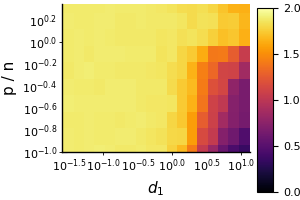

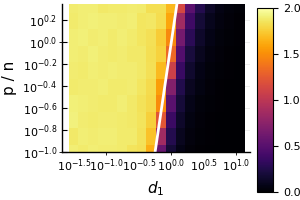

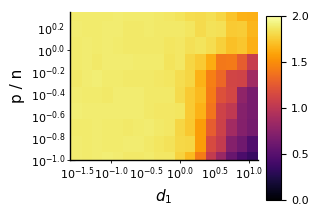

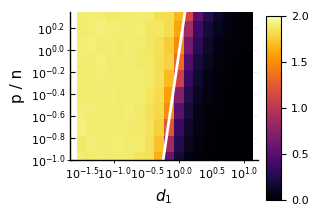

In [326]:
cos_rank1_IP_m = 2 * (1.0 .- dropdims(mean(abs.(cos_rank1_IP); dims = 3); dims = 3))

p1 = plot(reuse = false, size = (300, 200),
        xlabel = L"d_1", ylabel = "p / n",
        xscale = :log10, yscale = :log10,
        ylims = (minimum(c_list), maximum(c_list)),
        clims = (0.0, 2.0)
    )
p1 = heatmap!(theta_list, c_list, cos_rank1_IP_m[:, :, 1])

p2 = plot(reuse = false, size = (300, 200),
        xlabel = L"d_1", ylabel = "p / n",
        xscale = :log10, yscale = :log10,
        ylims = (minimum(c_list), maximum(c_list)),
        clims = (0.0, 2.0)
    )
p2 = heatmap!(theta_list, c_list, cos_rank1_IP_m[:, :, 2])
c_pl = range(minimum(c_list) / 10; stop = maximum(c_list) * 10, length = 50)
p2 = plot!(c_pl.^0.25, c_pl, color = "white", linewidth = 2, label = "")

display(p1)
display(p2)

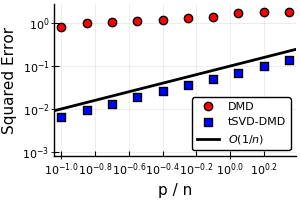

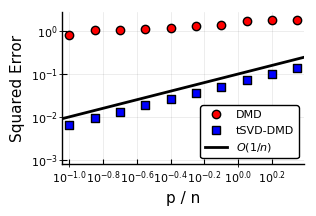

In [327]:
t_idx = 15
p1 = plot(reuse = false, size = (300, 200),
        xlabel = "p / n", ylabel = "Squared Error",
        xscale = :log10, yscale = :log10,
        xlims = (minimum(c_list) / 1.1, maximum(c_list) * 1.1)
    )
p1 = scatter!(c_list, cos_rank1_IP_m[:, t_idx, 1], 
        label = "DMD",
        marker = :circle, color = "red",
        markersize = 6
    )
p1 = scatter!(c_list, cos_rank1_IP_m[:, t_idx, 2], 
        label = "tSVD-DMD",
        marker = :square, color = "blue",
        markersize = 6
    )
c_pl = range(minimum(c_list) / 10; stop = maximum(c_list) * 10, length = 50)
p1 = plot!(c_pl, 0.1 * c_pl, 
        label = L"O(1/n)", 
        color = "black", linewidth = 2
    )

display(p1)

### Rank 4

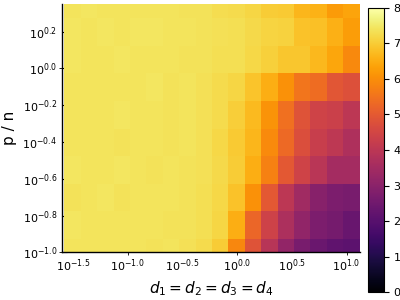

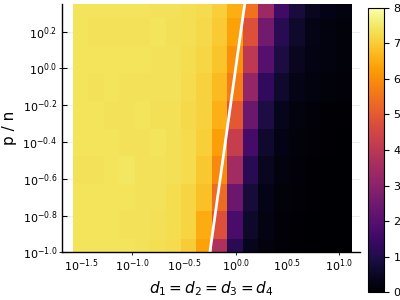

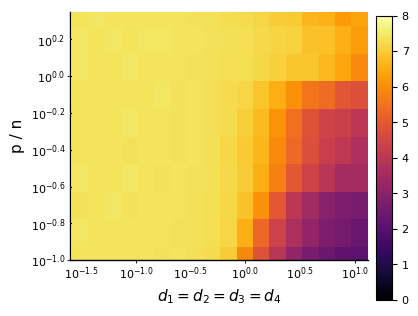

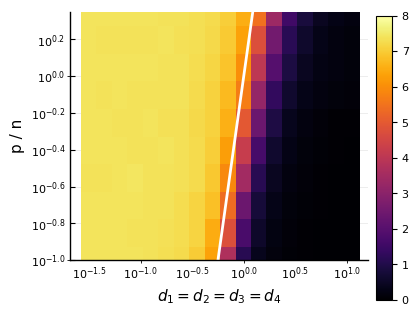

In [236]:
cos_rank4_IP_m = 2.0 * (1.0 .- dropdims(mean(abs.(cos_rank4_IP); dims = 3); dims = 3))
cos_rank4_IP_m = cat(sum(cos_rank4_IP_m[:, :, 1:4]; dims = 3), sum(cos_rank4_IP_m[:, :, 5:8]; dims = 3); dims = 3)
p1 = plot(reuse = false, size = (400, 300),
        xlabel = L"d_1 = d_2 = d_3 = d_4", ylabel = "p / n",
        xscale = :log10, yscale = :log10,
        ylims = (minimum(c_list), maximum(c_list)), 
        clims = (0.0, 8.0)
    )
p1 = heatmap!(theta_list, c_list, cos_rank4_IP_m[:, :, 1])

p2 = plot(reuse = false, size = (400, 300),
        xlabel = L"d_1 = d_2 = d_3 = d_4", ylabel = "p / n",
        xscale = :log10, yscale = :log10,
        ylims = (minimum(c_list), maximum(c_list)),
        clims = (0.0, 8.0)
    )
p2 = heatmap!(theta_list, c_list, cos_rank4_IP_m[:, :, 2])
c_pl = range(minimum(c_list) / 10; stop = maximum(c_list) * 10, length = 50)
p2 = plot!(c_pl.^0.25, c_pl, color = "white", linewidth = 2, label = "")

display(p1)
display(p2)

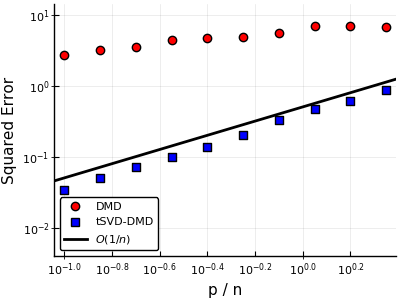

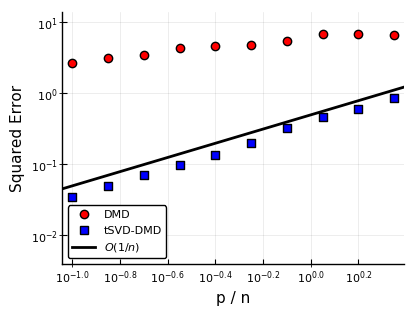

In [237]:
t_idx = 15
p1 = plot(reuse = false, size = (400, 300),
        xlabel = "p / n", ylabel = "Squared Error",
        xscale = :log10, yscale = :log10,
        xlims = (minimum(c_list) / 1.1, maximum(c_list) * 1.1)
    )
p1 = scatter!(c_list, cos_rank4_IP_m[:, t_idx, 1], 
        label = "DMD",
        marker = :circle, color = "red",
        markersize = 6
    )
p1 = scatter!(c_list, cos_rank4_IP_m[:, t_idx, 2], 
        label = "tSVD-DMD",
        marker = :square, color = "blue",
        markersize = 6
    )
c_pl = range(minimum(c_list) / 10; stop = maximum(c_list) * 10, length = 50)
p1 = plot!(c_pl, 0.5 * c_pl, 
        label = L"O(1/n)", 
        color = "black", linewidth = 2
    )

display(p1)

## AR Plots

### Rank 1

#### $\tau = 1$

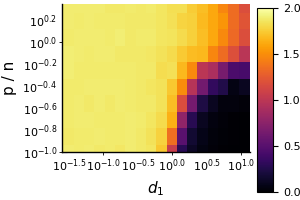

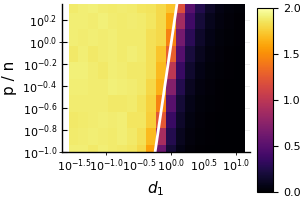

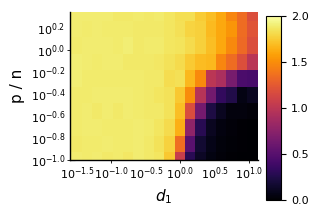

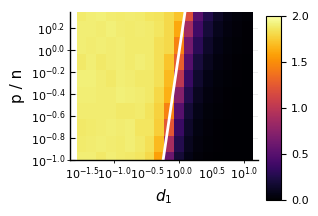

In [329]:
ar2_rank1_IP_m = 2 * (1.0 .- dropdims(mean(abs.(ar2_rank1_IP); dims = 3); dims = 3))

p1 = plot(reuse = false, size = (300, 200),
        xlabel = L"d_1", ylabel = "p / n",
        xscale = :log10, yscale = :log10,
        ylims = (minimum(c_list), maximum(c_list)),
        clims = (0.0, 2.0)
    )
p1 = heatmap!(theta_list, c_list, ar2_rank1_IP_m[:, :, 1])

p2 = plot(reuse = false, size = (300, 200),
        xlabel = L"d_1", ylabel = "p / n",
        xscale = :log10, yscale = :log10,
        ylims = (minimum(c_list), maximum(c_list)),
        clims = (0.0, 2.0)
    )
p2 = heatmap!(theta_list, c_list, ar2_rank1_IP_m[:, :, 2])
c_pl = range(minimum(c_list) / 10; stop = maximum(c_list) * 10, length = 50)
p2 = plot!(c_pl.^0.25, c_pl, color = "white", linewidth = 2, label = "")

display(p1)
display(p2)

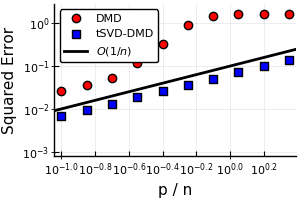

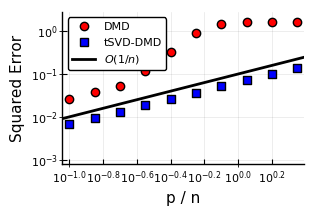

In [331]:
t_idx = 15
p1 = plot(reuse = false, size = (300, 200),
        xlabel = "p / n", ylabel = "Squared Error",
        xscale = :log10, yscale = :log10,
        xlims = (minimum(c_list) / 1.1, maximum(c_list) * 1.1)
    )
p1 = scatter!(c_list, ar2_rank1_IP_m[:, t_idx, 1], 
        label = "DMD",
        marker = :circle, color = "red",
        markersize = 6
    )
p1 = scatter!(c_list, ar2_rank1_IP_m[:, t_idx, 2], 
        label = "tSVD-DMD",
        marker = :square, color = "blue",
        markersize = 6
    )
c_pl = range(minimum(c_list) / 10; stop = maximum(c_list) * 10, length = 50)
p1 = plot!(c_pl, 0.1 * c_pl, 
        label = L"O(1/n)", 
        color = "black", linewidth = 2
    )

display(p1)

#### $\tau = 2$

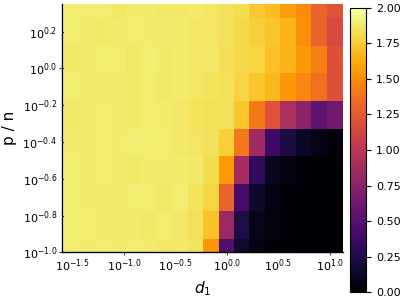

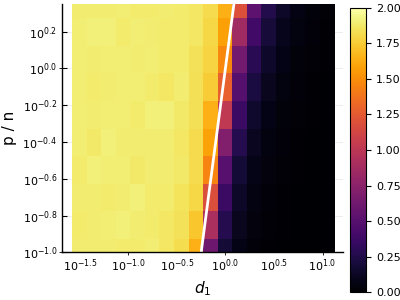

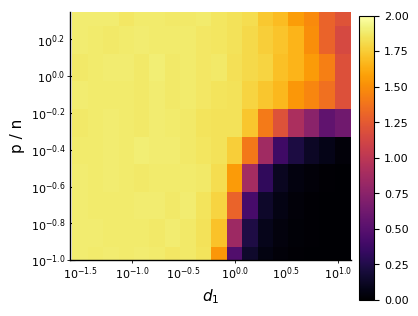

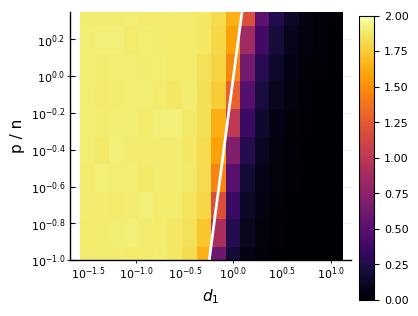

In [244]:
ar2_rank1_IP_m_tau2 = 2 * (1.0 .- dropdims(mean(abs.(ar2_rank1_IP_tau2); dims = 3); dims = 3))

p1 = plot(reuse = false, size = (400, 300),
        xlabel = L"d_1", ylabel = "p / n",
        xscale = :log10, yscale = :log10,
        ylims = (minimum(c_list), maximum(c_list)),
        clims = (0.0, 2.0)
    )
p1 = heatmap!(theta_list, c_list, ar2_rank1_IP_m_tau2[:, :, 1])

p2 = plot(reuse = false, size = (400, 300),
        xlabel = L"d_1", ylabel = "p / n",
        xscale = :log10, yscale = :log10,
        ylims = (minimum(c_list), maximum(c_list)),
        clims = (0.0, 2.0)
    )
p2 = heatmap!(theta_list, c_list, ar2_rank1_IP_m_tau2[:, :, 2])
c_pl = range(minimum(c_list) / 10; stop = maximum(c_list) * 10, length = 50)
p2 = plot!(c_pl.^0.25, c_pl, color = "white", linewidth = 2, label = "")

display(p1)
display(p2)

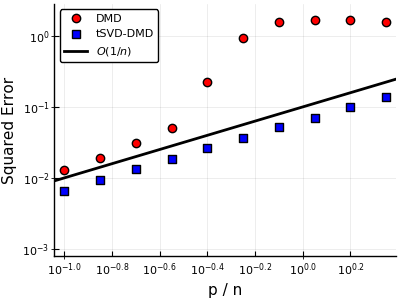

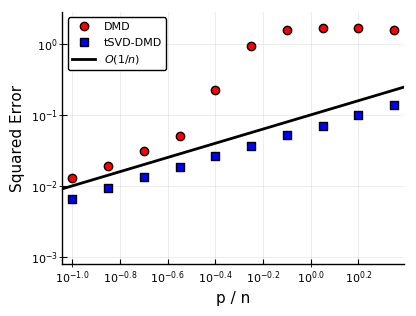

In [245]:
t_idx = 15
p1 = plot(reuse = false, size = (400, 300),
        xlabel = "p / n", ylabel = "Squared Error",
        xscale = :log10, yscale = :log10,
        xlims = (minimum(c_list) / 1.1, maximum(c_list) * 1.1)
    )
p1 = scatter!(c_list, ar2_rank1_IP_m_tau2[:, t_idx, 1], 
        label = "DMD",
        marker = :circle, color = "red",
        markersize = 6
    )
p1 = scatter!(c_list, ar2_rank1_IP_m_tau2[:, t_idx, 2], 
        label = "tSVD-DMD",
        marker = :square, color = "blue",
        markersize = 6
    )
c_pl = range(minimum(c_list) / 10; stop = maximum(c_list) * 10, length = 50)
p1 = plot!(c_pl, 0.1 * c_pl, 
        label = L"O(1/n)", 
        color = "black", linewidth = 2
    )

display(p1)

#### $\tau = 1$ and $2$

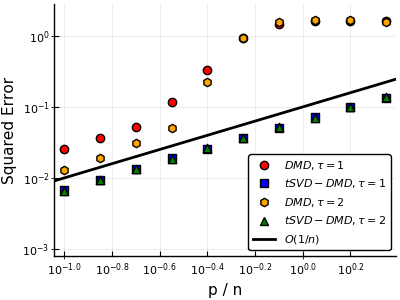

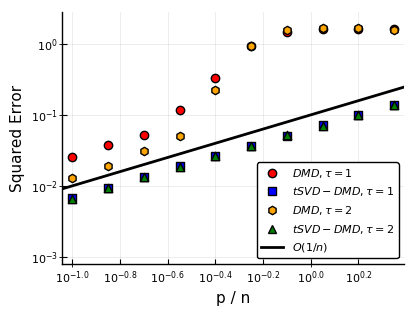

In [250]:
t_idx = 15
p1 = plot(reuse = false, size = (400, 300),
        xlabel = "p / n", ylabel = "Squared Error",
        xscale = :log10, yscale = :log10,
        xlims = (minimum(c_list) / 1.1, maximum(c_list) * 1.1)
    )

p1 = scatter!(c_list, ar2_rank1_IP_m[:, t_idx, 1], 
        label = L"DMD, \tau = 1",
        marker = :circle, color = "red",
        markersize = 6
    )
p1 = scatter!(c_list, ar2_rank1_IP_m[:, t_idx, 2], 
        label = L"tSVD-DMD, \tau = 1",
        marker = :square, color = "blue",
        markersize = 6
    )

p1 = scatter!(c_list, ar2_rank1_IP_m_tau2[:, t_idx, 1], 
        label = L"DMD, \tau = 2",
        marker = :hexagon, color = "orange",
        markersize = 6
    )
p1 = scatter!(c_list, ar2_rank1_IP_m_tau2[:, t_idx, 2], 
        label = L"tSVD-DMD, \tau = 2",
        marker = :utriangle, color = "green",
        markersize = 6
    )

c_pl = range(minimum(c_list) / 10; stop = maximum(c_list) * 10, length = 50)
p1 = plot!(c_pl, 0.1 * c_pl, 
        label = L"O(1/n)", 
        color = "black", linewidth = 2
    )


display(p1)

### Rank 2

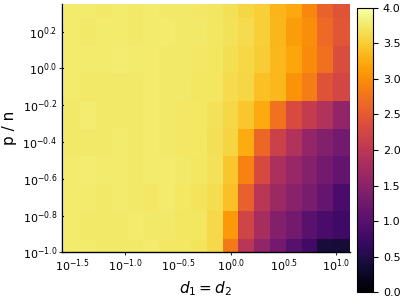

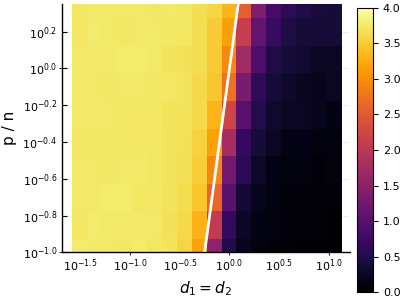

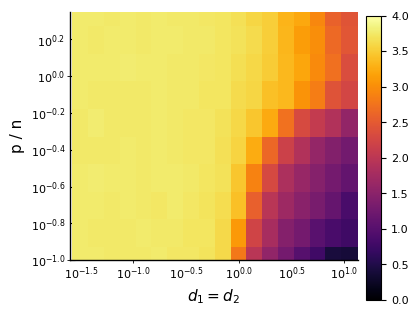

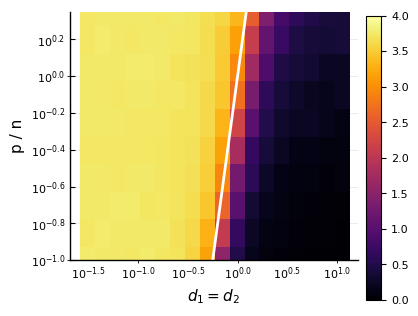

In [240]:
ar2_rank2_IP_m = 2.0 * (1.0 .- dropdims(mean(abs.(ar2_rank4_IP); dims = 3); dims = 3))
ar2_rank2_IP_m = cat(sum(ar2_rank2_IP_m[:, :, 1:2]; dims = 3), sum(ar2_rank2_IP_m[:, :, 3:4]; dims = 3); dims = 3)
p1 = plot(reuse = false, size = (400, 300),
        xlabel = L"d_1 = d_2", ylabel = "p / n",
        xscale = :log10, yscale = :log10,
        ylims = (minimum(c_list), maximum(c_list)), 
        clims = (0.0, 4.0)
    )
p1 = heatmap!(theta_list, c_list, ar2_rank2_IP_m[:, :, 1])

p2 = plot(reuse = false, size = (400, 300),
        xlabel = L"d_1 = d_2", ylabel = "p / n",
        xscale = :log10, yscale = :log10,
        ylims = (minimum(c_list), maximum(c_list)),
        clims = (0.0, 4.0)
    )
p2 = heatmap!(theta_list, c_list, ar2_rank2_IP_m[:, :, 2])
c_pl = range(minimum(c_list) / 10; stop = maximum(c_list) * 10, length = 50)
p2 = plot!(c_pl.^0.25, c_pl, color = "white", linewidth = 2, label = "")

display(p1)
display(p2)

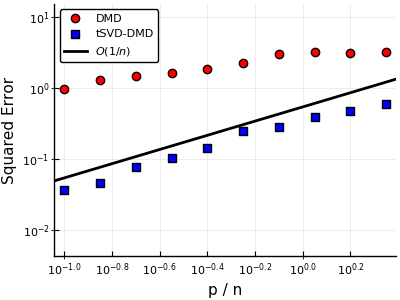

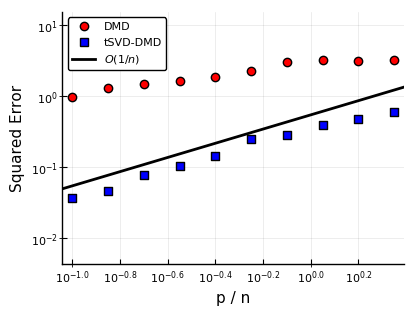

In [233]:
t_idx = 15
p1 = plot(reuse = false, size = (400, 300),
        xlabel = "p / n", ylabel = "Squared Error",
        xscale = :log10, yscale = :log10,
        xlims = (minimum(c_list) / 1.1, maximum(c_list) * 1.1)
    )
p1 = scatter!(c_list, ar2_rank2_IP_m[:, t_idx, 1], 
        label = "DMD",
        marker = :circle, color = "red",
        markersize = 6
    )
p1 = scatter!(c_list, ar2_rank2_IP_m[:, t_idx, 2], 
        label = "tSVD-DMD",
        marker = :square, color = "blue",
        markersize = 6
    )
c_pl = range(minimum(c_list) / 10; stop = maximum(c_list) * 10, length = 50)
p1 = plot!(c_pl, 0.55 * c_pl, 
        label = L"O(1/n)", 
        color = "black", linewidth = 2
    )

display(p1)

# Trace Plots


## Cosine

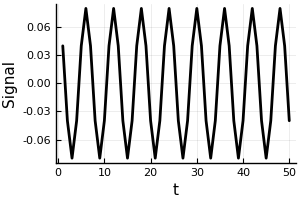

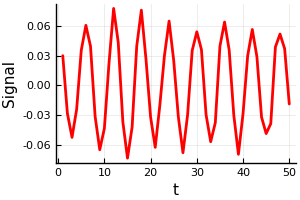

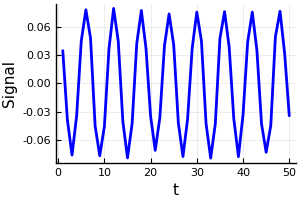

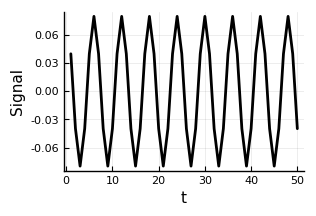

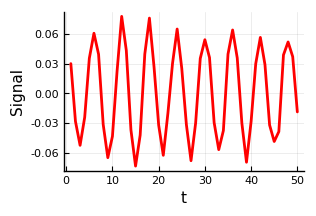

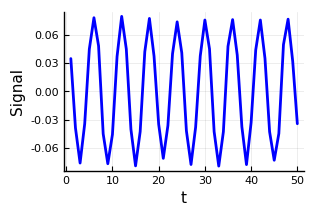

In [349]:
# Dimensions
p = 250 # Variables
c_idx = 7
c = c_list[c_idx] # c_list = 10.0.^(-1.0:0.15:0.4) # c = p / n

# Signal
f = acos(0.5)
t_idx = 18
theta_list = 10.0.^(-1.5:0.15:1.1) # SNR
theta = theta_list[t_idx]
k = 1 # Rank

n = Int(round(p / c)) # Samples


S = normalize(cos.(f * (1.0:n)))
Q = normalize(randn(p))

# Data, Rank-k Approximation
X = (theta * Q) * S' + randn(p, n) / sqrt(n)
Xk = tSVD(X, k)
            
# DMD Matrices
A = A_mat(X)
Ak = A_mat(Xk)
            
# DMD
what, Qhat = top_k_eig(A, k)
Shat = mapslices(normalize, (pinv(Qhat) * X)'; dims = 1)
wkhat, Qkhat = top_k_eig(Ak, k)
Skhat = mapslices(normalize, (pinv(Qkhat) * Xk)'; dims = 1)

x_idx = 1:50
p1 = plot(reuse = false, size = (300, 200),
        xlabel = "t", ylabel = "Signal"
    )
p1 = plot!(S[x_idx], 
        label = "",
        color = "black", linewidth = 2
    )

p2 = plot(reuse = false, size = (300, 200),
        xlabel = "t", ylabel = "Signal"
    )
p2 = plot!(sign(real.(Shat[:])' * S[:]) * real.(Shat[:])[x_idx], 
        label = "",
        color = "red", linewidth = 2
    )

p3 = plot(reuse = false, size = (300, 200),
        xlabel = "t", ylabel = "Signal"
    )
p3 = plot!(sign(real.(Skhat[:])' * S[:]) * real.(Skhat[:])[x_idx], 
        label = "",
        color = "blue", linewidth = 2
    )

display(p1)
display(p2)
display(p3)

## AR(2)

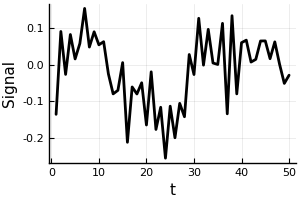

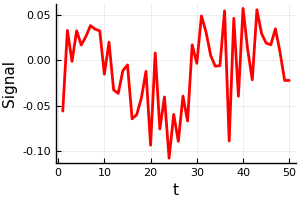

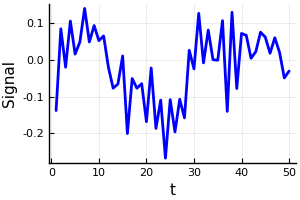

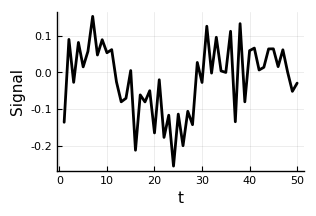

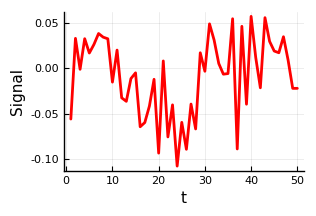

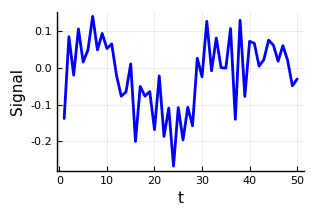

In [344]:
# Dimensions
p = 250 # Variables
c_idx = 10
c = c_list[c_idx] # c_list = 10.0.^(-1.0:0.15:0.4) # c = p / n

# Signal
ar = [1.0 / 6.0; 2.0 / 3.0] # Coefficients
ma = []
arma_std = 1.0
t_idx = 18
theta = theta_list[t_idx] # theta_list = 10.0.^(-1.5:0.15:1.1) # SNR
k = 1 # Rank

n = Int(round(p / c)) # Samples
S = normalize(gen_arma_sequence(n, ar, ma, arma_std))
Q = normalize(randn(p))

# Data, Rank-k Approximation
X = (theta * Q) * S' + randn(p, n) / sqrt(n)
Xk = tSVD(X, k)
            
# DMD Matrices
A = A_mat(X)
Ak = A_mat(Xk)
            
# DMD
what, Qhat = top_k_eig(A, k)
Shat = mapslices(normalize, (pinv(Qhat) * X)'; dims = 1)
wkhat, Qkhat = top_k_eig(Ak, k)
Skhat = mapslices(normalize, (pinv(Qkhat) * Xk)'; dims = 1)

x_idx = 1:50
p1 = plot(reuse = false, size = (300, 200),
        xlabel = "t", ylabel = "Signal"
    )
p1 = plot!(S[x_idx], 
        label = "",
        color = "black", linewidth = 2
    )

p2 = plot(reuse = false, size = (300, 200),
        xlabel = "t", ylabel = "Signal"
    )
p2 = plot!(sign(real.(Shat[:])' * S[:]) * real.(Shat[:])[x_idx], 
        label = "",
        color = "red", linewidth = 2
    )

p3 = plot(reuse = false, size = (300, 200),
        xlabel = "t", ylabel = "Signal"
    )
p3 = plot!(sign(real.(Skhat[:])' * S[:]) * real.(Skhat[:])[x_idx], 
        label = "",
        color = "blue", linewidth = 2
    )

display(p1)
display(p2)
display(p3)

# Cosines, sweeping over $\rho$

In [308]:
# Dimensions
p = 250 # Variables
c_idx = 7
c_list = 10.0.^(-1.0:0.15:0.4) # c = p / n
c = c_list[c_idx]
n = Int(round(p / c)) # Samples

# Signal
f_list = acos.(0.0:0.05:1.0)
theta_list = 10.0.^(-1.5:0.15:1.1) # SNR
k = 1 # Rank

# Simulation
trials = 100

# Outputs
cos_rank1_IP_rho = zeros(length(f_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
cos_rank1_IP_S_rho = zeros(length(f_list), length(theta_list), trials, 2 * k) * Complex(0, 0)
cos_rank1_eval_rho = zeros(length(f_list), length(theta_list), trials, 2 * k) * Complex(0, 0)

t1 = time()
for ff in 1:length(f_list)
    f = f_list[ff]
    S = normalize(cos.(f * (1.0:n)))
    
    for tt in 1:length(theta_list)
        theta = theta_list[tt]
        
        for tr in 1:trials
            Q = normalize(randn(p))
            
            # Data, Rank-k Approximation
            X = (theta * Q) * S' + randn(p, n) / sqrt(n)
            Xk = tSVD(X, k)
            
            # DMD Matrices
            A = A_mat(X)
            Ak = A_mat(Xk)
            
            # DMD
            what, Qhat = top_k_eig(A, k)
            Shat = mapslices(normalize, (pinv(Qhat) * X)'; dims = 1)
            wkhat, Qkhat = top_k_eig(Ak, k)
            Skhat = mapslices(normalize, (pinv(Qkhat) * Xk)'; dims = 1)
            
            cos_rank1_IP_rho[ff, tt, tr, 1:k] = (Q' * Qhat)[:]
            cos_rank1_IP_rho[ff, tt, tr, (k + 1):(2 * k)] = (Q' * Qkhat)[:]
            cos_rank1_IP_S_rho[ff, tt, tr, 1:k] = (S' * Shat)[:]
            cos_rank1_IP_S_rho[ff, tt, tr, (k + 1):(2 * k)] = (S' * Skhat)[:]
            cos_rank1_eval_rho[ff, tt, tr, 1:k] = what[:]
            cos_rank1_eval_rho[ff, tt, tr, (k + 1):(2 * k)] = wkhat[:]
        end
    end
end
t2 = time()
println(t2 - t1)

5569.293143987656


In [309]:
save("CAMSAP_Sims_2019July_cos_rank1_rho.jld2", 
    Dict("p" => p,
        "c_list" => c_list,
        "c_idx" => c_idx,
        "f_list" => f_list,
        "theta_list" => theta_list, 
        "k" => k,
        "trials" => trials,
        "cos_rank1_IP_rho" => cos_rank1_IP_rho,
        "cos_rank1_IP_S_rho" => cos_rank1_IP_S_rho,
        "cos_rank1_eval_rho" => cos_rank1_eval_rho,
        "t1" => t1, 
        "t2" => t2
    )
)

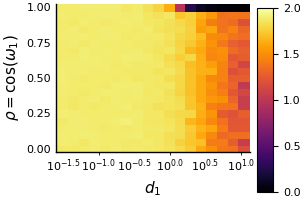

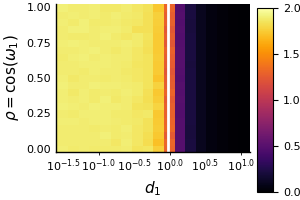

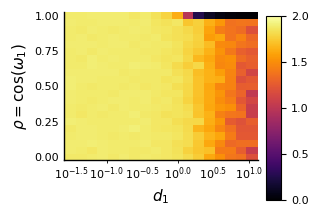

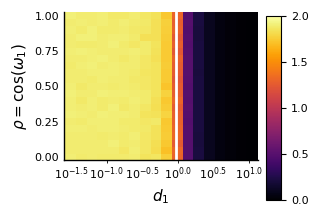

In [325]:
cos_rank1_IP_rho_m = 2 * (1.0 .- dropdims(mean(abs.(cos_rank1_IP_rho); dims = 3); dims = 3))

p1 = plot(reuse = false, size = (300, 200),
        xlabel = L"d_1", ylabel = L"\rho = \cos(\omega_1)",
        xscale = :log10,
        clims = (0.0, 2.0)
    )
p1 = heatmap!(theta_list, cos.(f_list), cos_rank1_IP_rho_m[:, :, 1])

p2 = plot(reuse = false, size = (300, 200),
        xlabel = L"d_1", ylabel = L"\rho = \cos(\omega_1)",
        xscale = :log10,
        clims = (0.0, 2.0)
    )
p2 = heatmap!(theta_list, cos.(f_list), cos_rank1_IP_rho_m[:, :, 2])
p2 = vline!([c_list[c_idx].^0.25], color = "white", linewidth = 2, label = "")

display(p1)
display(p2)